### Lagged cross-correlation

In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import os 
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt

from   GDa.session           import session_info, session

from frites.conn import conn_ccf

from tqdm        import tqdm

#### Reading LFP data for a session

In [2]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

In [3]:
ses.data.attrs["sfreq"] = ses.data.attrs["fsample"]

In [4]:
# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

#### Lagged cross-correlation

In [5]:
x_s, x_t = np.triu_indices(data.shape[0],k=1)
pairs    = np.array([x_s,x_t]).T

In [6]:
ccf = conn_ccf(data.values[...,::10], times=data.time[::10], roi=None, normalized=True, n_jobs=20, times_as_sample=True, verbose=None)

WARNING | No regions of interest are provided (roi). Default ones are created
Computing CCF between 1176 pairs


  0%|          | Estimating CCF : 0/1176 [00:00<?,       ?it/s]

In [9]:
x_s = np.array(ccf.attrs["sources"])
x_t = np.array(ccf.attrs["targets"])

In [21]:
# get lag at maximum peak
ccf_m = ccf.mean('trials')

In [22]:
lags = ccf['times'].data[np.where(ccf_m == ccf_m.max('times'))[1]]

In [ ]:
# plot the cross correlation
# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(12,12))
plt.title('Delays between brain regions')
ccf_m.plot(x='times', hue='roi')
plt.axvline(0., color='k')

# plot peak informations
for n_p in range(len(lags)):
    plt.axvline(lags[n_p], color=f"C{n_p}", linestyle='--', lw=1)
    t = plt.text(lags[n_p], 1., str(lags[n_p]), color=f"C{n_p}", ha='center')
    t.set_bbox(dict(facecolor='w', edgecolor='w'))

# add text
#neg = ("Negative times = target\nneeds to be moved\nback in time")
#pos = ("Positive times = target\nneeds to be moved\nlater in time")
#plt.text(-4000, .3, neg, ha='center', fontsize=15, fontweight='bold')
#plt.text(4000, .3, pos, ha='center', fontsize=15, fontweight='bold')
plt.ylim([-.2,.2])
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
plt.hist(np.hstack(lags),100, density=True);

In [ ]:
import frites

In [ ]:
frites.conn.conn_reshape_undirected(ccf)

In [23]:
ii=np.argsort(lags)

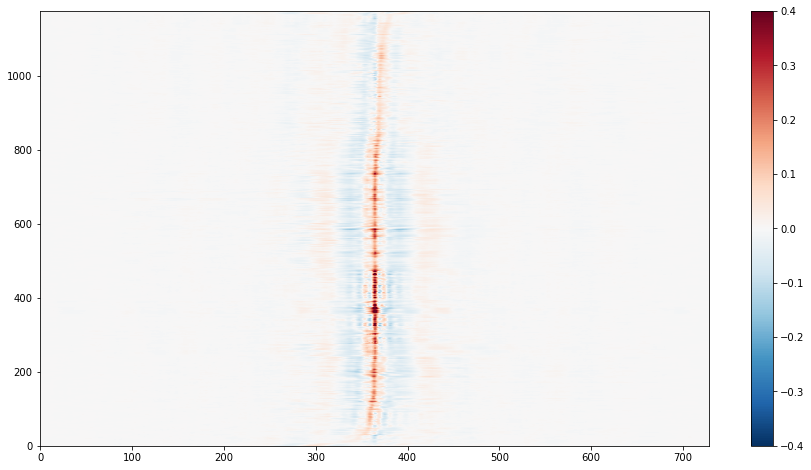

In [24]:
plt.figure(figsize=(15,8))
plt.imshow(ccf_m[ii,:], aspect="auto", cmap="RdBu_r", origin="lower", vmin=-.4, vmax=.4)
plt.colorbar()

In [21]:
lags

[array([  0., -65.,   0., ...,   0.,  -1.,   0.]),
 array([110.,   5.,   0., ...,   0.,   0.,   1.]),
 array([  0., -65.,   0., ...,   0.,   0.,   0.]),
 array([ 0., -5., -1., ...,  1.,  0.,  0.]),
 array([ 0., -1.,  0., ...,  0.,  1.,  1.]),
 array([0., 4., 0., ..., 0., 1., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 6., 0., ..., 0., 0., 0.]),
 array([18., -6., -1., ...,  0.,  0.,  0.]),
 array([103., -57.,   0., ...,   0.,   0.,   0.]),
 array([ 0., -5.,  0., ...,  1.,  0.,  0.]),
 array([0., 4., 0., ..., 0., 0., 0.]),
 array([0., 4., 0., ..., 0., 0., 0.]),
 array([   0., -144.,    0., ...,    0.,    0.,    0.]),
 array([ 90., -49.,   0., ...,   0.,   0.,   0.]),
 array([112.,   0.,   0., ...,   0.,   0.,   0.]),
 array([  0., -22.,   0., ...,   0.,   0.,   0.]),
 array([0., 4., 0., ..., 0., 0., 0.]),
 array([ 0., -5.,  0., ...,  0.,  0.,  0.]),
 array([0., 2., 0., ..., 0., 0., 0.]),
 array([0., 4., 0., ..., 0., 0., 0.]),
 array([-1.,  4.,  0., ...,  0.,  0.,  0.]),
 arr

In [13]:
from   GDa.temporal_network  import temporal_network
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':'/home/vinicius/storage1/projects/GrayData-Analysis/GrayLab',
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

###################################################################################
# Load coherence data
###################################################################################

### Methods to read coherence files
def get_coh_file(ks=None, surr=False, mode="morlet"):
    _COH_FILE = f'super_tensor_k_{ks}_surr_{surr}_{mode}.nc'
    return _COH_FILE


q_thr = None
## Default threshold
kw = dict(q=q_thr)

# Instantiating a temporal network object without thresholding the data
net =  temporal_network(coh_file=get_coh_file(ks=500, surr=False, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                        session=1, date='150128', trial_type=[1],
                        behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                        verbose=True, **kw)

Text(0.5, 0, 'lag')

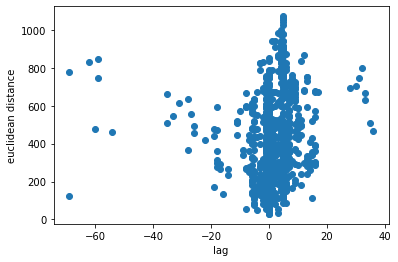

In [25]:
plt.plot(lags, net.super_tensor.attrs["d_eu"], "o")
plt.ylabel("euclidean distance")
plt.xlabel("lag")

In [19]:
np.sum(x_s-net.super_tensor.attrs["sources"])

0

In [30]:
net.super_tensor.attrs["channels_labels"]

array([  1,   4,   9,  13,  16,  17,  22,  23,  26,  27,  29,  34,  39,
        43,  54,  63,  66,  92,  95, 105, 106, 110, 121, 122, 127, 128,
       132, 134, 135, 146, 148, 149, 150, 156, 161, 176, 177, 178, 183,
       201, 203, 205, 210, 219, 221, 224, 242, 248, 250])

In [31]:
net.session_info["channels_labels"]

array([  1,   4,   9,  13,  16,  17,  22,  23,  26,  27,  29,  34,  39,
        43,  54,  63,  66,  92,  95, 105, 106, 110, 121, 122, 127, 128,
       132, 134, 135, 146, 148, 149, 150, 156, 161, 176, 177, 178, 183,
       201, 203, 205, 210, 219, 221, 224, 242, 248, 250])